### Analyze QC'd & standardized Ethovision location data

The purpose of the script is to analyze the QC'd & standardized Ethovision location data to train two autoencoder. One for each phase of the 

This script includes code to import the location data from files exported by "etho_data_Step_4_tabular_data" and trains an encoder.

Training parameters were chosen based on the results of a paramter sweep (etho_data_Step_A5_psweep_zf_Autoencoder) that can be found in /results/Hparameter_sweep.csv

Uses second light cycle data

by: Dr. Adrian Green, *Spring 2022*

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"           # Only one GPU will be seen

# tensorflow
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

print("tensorflow version",tf.__version__,". Executing eagerly?",tf.executing_eagerly())
print("Number of GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

1 Physical GPUs, 1 Logical GPUs
tensorflow version 2.6.0 . Executing eagerly? True
Number of GPUs:  1


2022-08-16 14:54:23.388730: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 14:54:23.934970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30997 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


## Step 1: Loading the required libraries

In [2]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import MinMaxScaler 

import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Dropout
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras import regularizers 

# Local functions
import sys

from Green_scripts_v1 import save_obj, load_obj, agg_by_time, zf_Control_behavior_KStest, zf_behavior_KStest
from Green_scripts_v1 import phase_diff_behavior, find_abnormal
from Green_scripts_v1 import build_autoencoder

# Performance evaluation routines
from tkmetrics import display_conf_matrix

## Step 2: Loading and processing data
Create X (timepoint, x-center, y-center, distance moved, velocity) and y (classID) arrays from bulk input or load in processed data

In [3]:
# load all location data for processing
basedirname = '/home2/ajgreen4/ZF_Projects/HTS_Behavior_Project'
pcwKey = pd.read_csv(basedirname + "/Raw_Data_Files/plateTable.csv")

In [4]:
# load all location data for processing
train_data_path = basedirname + '/results/'
train_X = np.load(train_data_path + '5dpf_2nd_cycle_movement_X_data.npy') # 3D numpy array
train_z = pd.read_csv(train_data_path + "5dpf_2nd_cycle_movement_z_data.csv") # experimental data

# Loading the dataset 
train_movement = pd.read_csv(train_data_path + "5dpf_2nd_cycle_movement-etho_data_Step3_threshold_output_cleaned.csv")

all_movement = train_movement.merge(pcwKey.drop(['ClassID_Dark', 'Activity_Dark', 
                                               'ClassID_Light', 'Activity_Light'], axis=1))
all_z = train_z.merge(pcwKey.drop(['ClassID_Dark', 'Activity_Dark', 
                                               'ClassID_Light', 'Activity_Light'], axis=1))

control_movement = all_movement.loc[(all_movement['Conc'] == 0.0)].copy()


# subset training data - light: < 900, dark: >= 900
all_X = np.zeros([len(train_X),int((train_X.shape[1])/2),train_X.shape[2]])

# subset 3D traing data
for i in range(len(train_X)):
    H = train_X[i]
    mask = (H[:, 0] >= 900) # light: < 900, dark: >= 900
    all_X[i] = H[mask, :]
#     print(all_X.shape)


### Graph data to confirm correct subset

#### Graph all plate data to confirm no obvious outliers

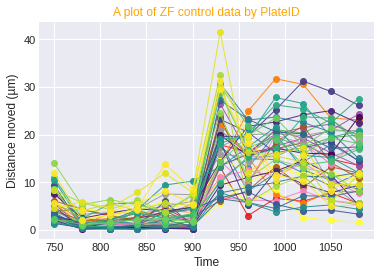

In [5]:
test = agg_by_time(control_movement, 0, 1560, 30, ['PlateID', 'ChemID', 'Well', 'Conc'])

df = test.groupby(by=['PlateID', 'Trial time'], 
                 sort=False)['Distance moved'].mean().reset_index()
  

num_plates = int(len(df['PlateID'].unique())/2)

# Change the style of plot
plt.style.use('seaborn-darkgrid')
 
# Create a color palette
top = plt.get_cmap('Set1', num_plates)
bottom = plt.get_cmap('viridis', num_plates)

newcolors = np.vstack((top(np.linspace(0, 1, num_plates)),
                       bottom(np.linspace(0, 1, num_plates))))
palette = ListedColormap(newcolors, name='Set1_viridis')

# palette = plt.get_cmap('viridis', len(df['PlateID'].unique()))
 
# Plot multiple lines
num=0
for PlateID in df['PlateID'].unique():
    zf_movement = df.loc[(df['PlateID'] == PlateID)].drop(['PlateID'], axis=1)
    num+=1
    plt.plot('Trial time', 'Distance moved', data=zf_movement, marker='o', color=palette(num), linewidth=1, alpha=0.9, label=PlateID)

# Add legend
# plt.legend(loc=2, ncol=2)
 
# Add titles
plt.title("A plot of ZF control data by PlateID", loc='center', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.ylabel("Distance moved (µm)")

# Show the graph
plt.show()

#### Graph contol data to confirm correct subcycle (i.e light cycle two)

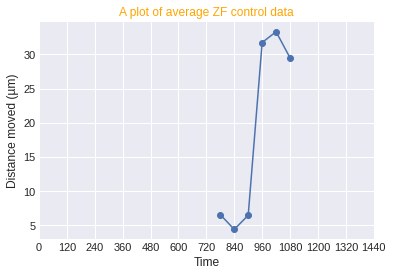

In [6]:
test = agg_by_time(control_movement, 0, 1560, 60, ['PlateID', 'ChemID', 'Well', 'Conc'])

df = test.groupby(by=['Trial time'], 
                 sort=False)['Distance moved'].mean().reset_index()

# plot
plt.plot('Trial time', 'Distance moved', data=df, linestyle='-', marker='o')
# Add titles
plt.title("A plot of average ZF control data", loc='center', fontsize=12, fontweight=0, color='orange')
plt.xlabel("Time")
plt.xticks( range(0,1560,120) )   # Put x axis ticks every 120 units.
plt.ylabel("Distance moved (µm)")

plt.show()

Compare controls from each experiment to all controls

In [7]:
%%time

Plates  = control_movement['PlateID'].unique()
Plates.sort()

first = True
for i in range(0,len(Plates)):
    results = zf_Control_behavior_KStest(control_movement, 
                               control_movement.loc[(control_movement['PlateID'] == Plates[i])], 3)
    results = results.assign(L_Activity=np.nan, D_Activity=np.nan)   
    results['L_Activity'] = np.where(results['LC2_mean'] > results['LC1_mean'], 
                                               'hyperactive', 'hypoactive')
    results['D_Activity'] = np.where(results['DC2_mean'] > results['DC1_mean'], 
                                               'hyperactive', 'hypoactive')
    results.loc[(results['L_pvalue'] > 0.01), 'L_Activity'] = 'normal'
    results.loc[(results['D_pvalue'] > 0.01), 'D_Activity'] = 'normal'
    results['N'] = all_z.loc[(all_z['PlateID'] == Plates[i]) & (all_z['Conc'] == 0.0), 'PlateID'].count()
    if first:
        all_results = results
        first = False
    else:
        all_results = all_results.append(results)

print('Comparison of Training controls: ')
all_results['PlateID'] = Plates
all_results.head(all_results.shape[0])

Comparison of Training controls: 
CPU times: user 1min 29s, sys: 51.2 s, total: 2min 20s
Wall time: 2min 17s


,L_pvalue,D_pvalue,LC1_mean,DC1_mean,LC2_mean,DC2_mean,L_Activity,D_Activity,N,PlateID
0,0.229159,0.131657,0.003879,0.021012,0.002059,0.027132,normal,normal,12,19052
0,0.884233,0.011519,0.003879,0.021012,0.002375,0.028092,normal,normal,10,19054
0,0.258905,0.003866,0.003879,0.021012,0.002940,0.007009,normal,hypoactive,12,19216
0,0.475765,0.050690,0.003879,0.021012,0.001897,0.008688,normal,normal,12,19217
0,0.405405,0.173612,0.003879,0.021012,0.001632,0.013573,normal,normal,12,19221
0,0.002540,0.012268,0.003879,0.021012,0.000809,0.007055,hypoactive,normal,12,19231
0,0.662531,0.097878,0.003879,0.021012,0.005134,0.029549,normal,normal,12,19237
0,0.105159,0.029467,0.003879,0.021012,0.007152,0.031128,normal,normal,15,19239
0,0.501140,0.262791,0.003879,0.021012,0.002921,0.024506,normal,normal,10,19267
0,0.824667,0.634525,0.003879,0.021012,0.003855,0.025843,normal,normal,15,19275


In [8]:
larvae = len(all_z)
wt_larvae = all_results['N'].sum()
tx_larvae = len(all_z.loc[(all_z['Conc'] > 0.0)])

print('Total number of larvae: ', larvae)
print('Total number of WT larvae: ', wt_larvae)
print('Total number of TX larvae: ', tx_larvae)

Total number of larvae:  3425
Total number of WT larvae:  706
Total number of TX larvae:  2719


## Step 3: Train low movement dark autoencoder

#### **Filter data for experiments with controls that had low (hypoactive) movement in the dark and preserve index information**

In [9]:
low_Plates  = all_results.loc[(all_results['D_Activity'] == 'hypoactive'), 'PlateID'].unique()
low_movement = pd.DataFrame([], columns=all_movement.columns)
index = []
for plate in low_Plates:
    low_movement = low_movement.append(all_movement.loc[(all_movement['PlateID'] == plate)])
    index = np.append(index, np.where(all_z['PlateID'] == plate)[0])

#### **Compare treated and control from these experiments using KS test**
 - collapse data to light phase (**L**), dark phase (**D**)
 - see Reif,D.M. et al. (2016) Arch Toxicol, 90, 1459–1470

In [10]:
%%time
p_val = 0.05
print('KS test - by fish')
results = zf_behavior_KStest(low_movement, 3)

sig_results = results.loc[(results['D_pvalue'] < p_val)]
sig_results = sig_results.assign(L_Activity=np.nan, D_Activity=np.nan)   
sig_results['L_Activity'] = np.where(sig_results['LT_mean']>sig_results['LC_mean'], 
                                           'hyperactive', 'hypoactive')
sig_results['D_Activity'] = np.where(sig_results['DT_mean']>sig_results['DC_mean'], 
                                           'hyperactive', 'hypoactive')
sig_results.loc[(sig_results['L_pvalue'] > p_val), 'L_Activity'] = 'normal'
sig_results.loc[(sig_results['D_pvalue'] > p_val), 'D_Activity'] = 'normal'

print('Number of Chemicals: ', len(results['ChemID'].unique()), '\n')
print('All treatments (Chemicals + Doses): ', len(results), '\n')
print('Significant treatments: ', len(sig_results), '\n')

print('\033[1m' + 'Chemicals:' + '\033[0m')
for chem in low_movement['ChemID'].unique():
    print(pcwKey.loc[(pcwKey['ChemID']==chem)].iloc[0,6])
    
print('\n\033[1m' + 'Chemicals with Significant behavioral effects:' + '\033[0m')
for chem in sig_results['ChemID'].unique():
    print(pcwKey.loc[(pcwKey['ChemID']==chem)].iloc[0,6])
    
sig_results.head(sig_results.shape[0])

KS test - by fish
Number of Chemicals:  6 

All treatments (Chemicals + Doses):  34 

Significant treatments:  6 

Chemicals:
Abamectin
Dibenzo[e-l]pyrene
N-methylperfluoro-1-octanesulfonamidoacetic acid
N-ethylperfluoro-1-octanesulfonamidoacetic acid
(Heptafluoropropyl)trimethylsilane
Nonafluoropentanamide

Chemicals with Significant behavioral effects:
Abamectin
(Heptafluoropropyl)trimethylsilane
CPU times: user 18.4 s, sys: 424 ms, total: 18.8 s
Wall time: 17.8 s


,ChemID,Conc,L_pvalue,D_pvalue,LC_mean,DC_mean,LT_mean,DT_mean,L_Activity,D_Activity
2,944.0,0.4,0.233738,0.004763,0.002940,0.007009,0.000741,0.000649,normal,hypoactive
3,944.0,0.5,0.633628,0.016867,0.002940,0.007009,0.001651,0.001217,normal,hypoactive
4,944.0,0.6,0.725275,0.004396,0.002940,0.007009,0.000714,0.000012,normal,hypoactive
14,4340.0,100.0,0.070913,0.034056,0.001342,0.009341,0.002585,0.021290,normal,hyperactive
15,4340.0,66.5,0.299200,0.002915,0.001342,0.009341,0.002048,0.026494,normal,hyperactive
17,4340.0,11.1,0.535397,0.006837,0.001342,0.009341,0.002072,0.023961,normal,hyperactive


#### **Select hyper and hypo active larvae.**

- Retrieve data for chemicals that cause a significant change in behavior
- Select Q70th for hyperactive and Q30th for hypoactive larvae and label as abnormal (1)
- Label all other treated larvae as unknown (2)
This will inform which larval data will be used as positive controls for ML training

In [11]:
hyperactive_zfs = phase_diff_behavior(low_movement, sig_results, 'hyperactive', phase='Dark')
hypoactive_zfs = phase_diff_behavior(low_movement, sig_results, 'hypoactive', phase='Dark')
hyperactive_zfs = hyperactive_zfs.sort_values(by='meanDM', ascending=False, kind='mergesort', ignore_index=True)
hypoactive_zfs = hypoactive_zfs.sort_values(by='meanDM', ascending=True, kind='mergesort', ignore_index=True)

print('Total number of abnormal larvae: ', (len(hyperactive_zfs) + len(hypoactive_zfs)))
print('Total number of hyperactive larvae: ', len(hyperactive_zfs))
print('Total number of hypoactive larvae: ', len(hypoactive_zfs))

Total number of abnormal larvae:  44
Total number of hyperactive larvae:  20
Total number of hypoactive larvae:  24


In [12]:
test = pcwKey.copy()
[test, hchecksum] = find_abnormal(hyperactive_zfs, test, 'Hyperactive', 'Dark')
delta_class = len(test.loc[(test['ClassID_Dark'] == 1)]) - len(pcwKey.loc[(pcwKey['ClassID_Dark'] == 1)])
print(hchecksum, 'individuals are definitely hyperactive and', delta_class, 'ClassID_Dark changed')
[test, checksum] = find_abnormal(hypoactive_zfs, test, 'Hypoactive', 'Dark')
delta_class = len(test.loc[(test['ClassID_Dark'] == 1)]) - len(pcwKey.loc[(pcwKey['ClassID_Dark'] == 1)])
delta_class = delta_class if delta_class == 0 else delta_class-hchecksum # correct delta only if class ids were changed
print(checksum, 'individuals are definitely hypoactive and', delta_class, 'ClassID_Dark changed')
z = all_z.merge(test)
test.to_csv("/home2/ajgreen4/ZF_Projects/HTS_Behavior_Project/Raw_Data_Files/plateTable.csv", index=False, na_rep='NA')

6 individuals are definitely hyperactive and 6 ClassID_Dark changed
7 individuals are definitely hypoactive and 7 ClassID_Dark changed


#### Summary values

In [13]:
z = z.loc[index]
y = z['ClassID_Dark']
X = np.zeros([len(y),int((all_X.shape[1])),all_X.shape[2]])

j = 0
for i in index:
    i = int(i)
    X[j] = all_X[i,:,:]
    j+=1

larvae = len(z)
wt_larvae = len(y[y==0])
tx_larvae = len(y[y==1])

print('Total number of larvae: ', larvae)
print('Total number of WT larvae: ', wt_larvae)
print('Total number of TX larvae: ', tx_larvae)

Total number of larvae:  356
Total number of WT larvae:  68
Total number of TX larvae:  13


### Train an encoder and display results

2022-08-16 14:57:56.505415: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-16 15:06:53.113491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-16 15:40:25.688089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-16 16:08:36.318994: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-16 16:25:48.486980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-08-16 16:43:40.165335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


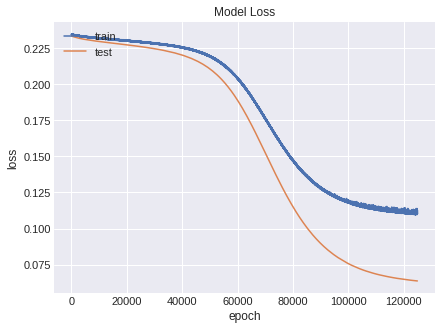

CPU times: user 1h 17min 45s, sys: 4min 31s, total: 1h 22min 16s
Wall time: 1h 45min 56s


In [14]:
%%time
if tx_larvae:
    display = 0 # 1 = display output graphs, 0 = display and write graphs to file

    # Scaling the data to make it suitable for the auto-encoder 
    scaler = MinMaxScaler()
    # Cleaning the data to make it suitable for the Auto-encoder
    X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    X_normal_scaled = X_scaled[y == 0] 
    X_abnormal_scaled = X_scaled[y == 1] 

    # Defining and Training the Auto-encoder
    hparams = {
        'HP_EncoderLayers': 8,
        'HP_DecoderLayers': 6,
        'HP_Kern': 'normal',
        'HP_EDrop': 0.2,
        'HP_DDrop': 0.2,
        'HP_OPTIMIZER': 'adadelta',
        'HP_ACTIVATION': 'tanh',
        'HP_L1': 1e-05,
        'HP_L2': 1e-05
    }

    tf.keras.backend.clear_session()  # memory consumption is constant over time.
    if 1: # train using full autoencoder
        autoencoder, encoder = build_autoencoder(X.shape[1:], hparams)

        # Training the Auto-encoder network 
        history = autoencoder.fit(X_normal_scaled, X_normal_scaled,
                                  batch_size = wt_larvae, 
                                  validation_data=(X_abnormal_scaled, X_abnormal_scaled), 
                                  epochs = 125000, shuffle = True, verbose=0)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    #     plt.ylim(0, 10000) 
    plt.xlabel('epoch')
    #     plt.xlim(5,40) 
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

    all_y_pred = []

### Train final logistic regression layer and display cross-validation results

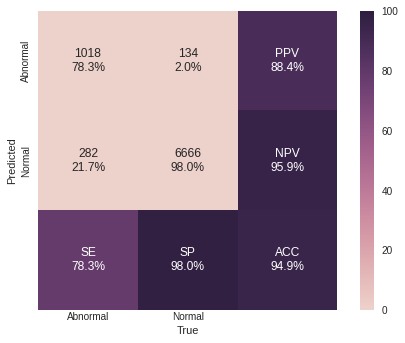



Kappa:  0.8
Auroc:  0.8817
Encoder:  /home2/ajgreen4/ZF_Projects/HTS_Behavior_Project/results/models/Dark-Low-Encoder-Kappa-0.8.h5
CPU times: user 22.9 s, sys: 27.2 s, total: 50.2 s
Wall time: 23.7 s


In [15]:
%%time
if tx_larvae:
    # Encoding the data and visualizing the encoded data
    normal_hidden_rep = encoder.predict(X_normal_scaled) 
    abnormal_hidden_rep = encoder.predict(X_abnormal_scaled) 

    # Combining the encoded points into a single table 
    encoded_X = np.append(normal_hidden_rep, abnormal_hidden_rep, axis = 0)
    # y_pred = np.argmax(encoded_X, axis=1) # if using softmax
    y_normal = np.zeros(normal_hidden_rep.shape[0]) 
    y_abnormal = np.ones(abnormal_hidden_rep.shape[0]) 
    encoded_y = np.append(y_normal, y_abnormal) 

    for i in range(100):
        # Splitting the encoded data for linear classification 
        X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, 
                                                                                            test_size = 0.2) 
        # Building the logistic regression model 
        lrclf = LogisticRegression(solver='lbfgs', max_iter=4000)
        lrclf.fit(X_train_encoded, y_train_encoded) 

        # Storing the predictions of the linear model 
        y_pred = lrclf.predict(encoded_X) 

        all_y_pred = np.append(all_y_pred, y_pred)

        tf.keras.backend.clear_session()  # memory consumption is constant over time.


    expanded_encoded_y = np.tile(encoded_y,i+1)
    metrics = display_conf_matrix(all_y_pred, expanded_encoded_y, Display=True)
    Emodelname = '/home2/ajgreen4/ZF_Projects/HTS_Behavior_Project/results/models/Dark-Low-Encoder-'+'Kappa-'+str(metrics[0])+'.h5'
    encoder.save(Emodelname)

    # exit()
    print('Encoder: ', Emodelname)

### Display final model results

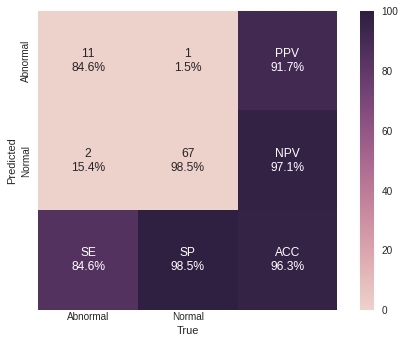



Kappa:  0.858
Auroc:  0.9157
File saved:  /home2/ajgreen4/ZF_Projects/HTS_Behavior_Project/results/models/ Dark-Low-Linear-Kappa-0.858 .pkl


In [16]:
if tx_larvae:
    display = 1 # 1 = display output graphs, 0 = display and write graphs to file

    # Storing the predictions of the linear model 
    y_pred = lrclf.predict(encoded_X) 
    model = lrclf
    metrics = display_conf_matrix(y_pred, encoded_y, Display=True)
    pkl_filename = 'Dark-Low-Linear-'+'Kappa-'+str(metrics[0])

    # Evaluating the performance of the linear model 
    if not display: # display
        metrics = display_conf_matrix(y_pred, encoded_y, Display=False)
        metrics = display_conf_matrix(y_pred, encoded_y, Display=True, 
                                      Gmodelname='Dark-Low-Linear-Kappa-'+str(metrics[0]),
                                      Save_path='/home2/ajgreen4/ZF_Projects/HTS_Behavior_Project/results/Output_CMs/')

    if 1:    
        save_obj(lrclf, '/home2/ajgreen4/ZF_Projects/HTS_Behavior_Project/results/models/', pkl_filename)
else:
    print("No abnormals therefore no model created")

## Release resources